### 0. Loading dependencies

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scipy
import statsmodels.formula.api as smf
import random
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import iqr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import warnings
# String styling
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### 1.1 Data Preparation: Data Cleaning, Relabeling, Wrangling and splitting subset.

In [2]:
#Fill Nan values is salary column
df_salary = pd.read_csv('dataset/salary.csv')
df_salary = df_salary.fillna(df_salary.salary.mean())

#Rename as per metadata
df_salary =df_salary.rename(columns ={'male':'gender', 'experior':'Experience', 'yearsabs':'years_absent'})
df_salary.gender = ['male' if i == 1 else 'female' for i in df_salary.gender]

df_salary.position = ['Jnr_employee' if i == 1 else 'Manager' if  i == 2 
                      else 'Executive' for i in df_salary.position]

df_salary.Field = ['Engineering' if i == 1 else 'Finance' if i == 2
                   else 'Human Resource' if i == 3 else 'Marketing' 
                   for i in df_salary.Field]    
df_salary = pd.DataFrame(df_salary)
df_salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,gender,Field,years_absent
0,53000.0,0,0,0,1.17,1,0,Jnr_employee,male,Human Resource,0
1,58000.0,1,0,0,1.24,1,0,Jnr_employee,male,Finance,0
2,45500.0,0,0,0,1.21,1,0,Jnr_employee,male,Human Resource,2
3,35782.0,0,2,1,0.99,1,0,Jnr_employee,male,Marketing,1
4,34731.0,0,2,2,0.91,1,0,Jnr_employee,male,Marketing,1


In [3]:
#Splitting the data into df_train train and test set

df_train, df_test = train_test_split(df_salary, test_size=0.2, random_state=42)
df_train.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,gender,Field,years_absent
320,80137.00000,5,21,20,1.04,1,0,Executive,male,Finance,0
329,39777.00000,10,17,10,0.86,1,0,Manager,male,Human Resource,1
173,61453.00000,0,15,0,1.21,1,0,Manager,male,Engineering,0
272,53665.00000,0,25,12,0.92,1,0,Executive,male,Engineering,0
493,44410.85547,7,12,10,0.72,1,0,Manager,female,Human Resource,51
...,...,...,...,...,...,...,...,...,...,...,...
106,65212.00000,7,3,3,1.18,1,0,Manager,male,Finance,0
270,68894.00000,16,7,7,0.99,1,1,Executive,male,Engineering,0
348,52738.91406,2,26,6,0.74,1,0,Executive,male,Engineering,1
435,55210.00000,1,5,5,1.23,0,1,Jnr_employee,female,Finance,1


## Analyze relationships

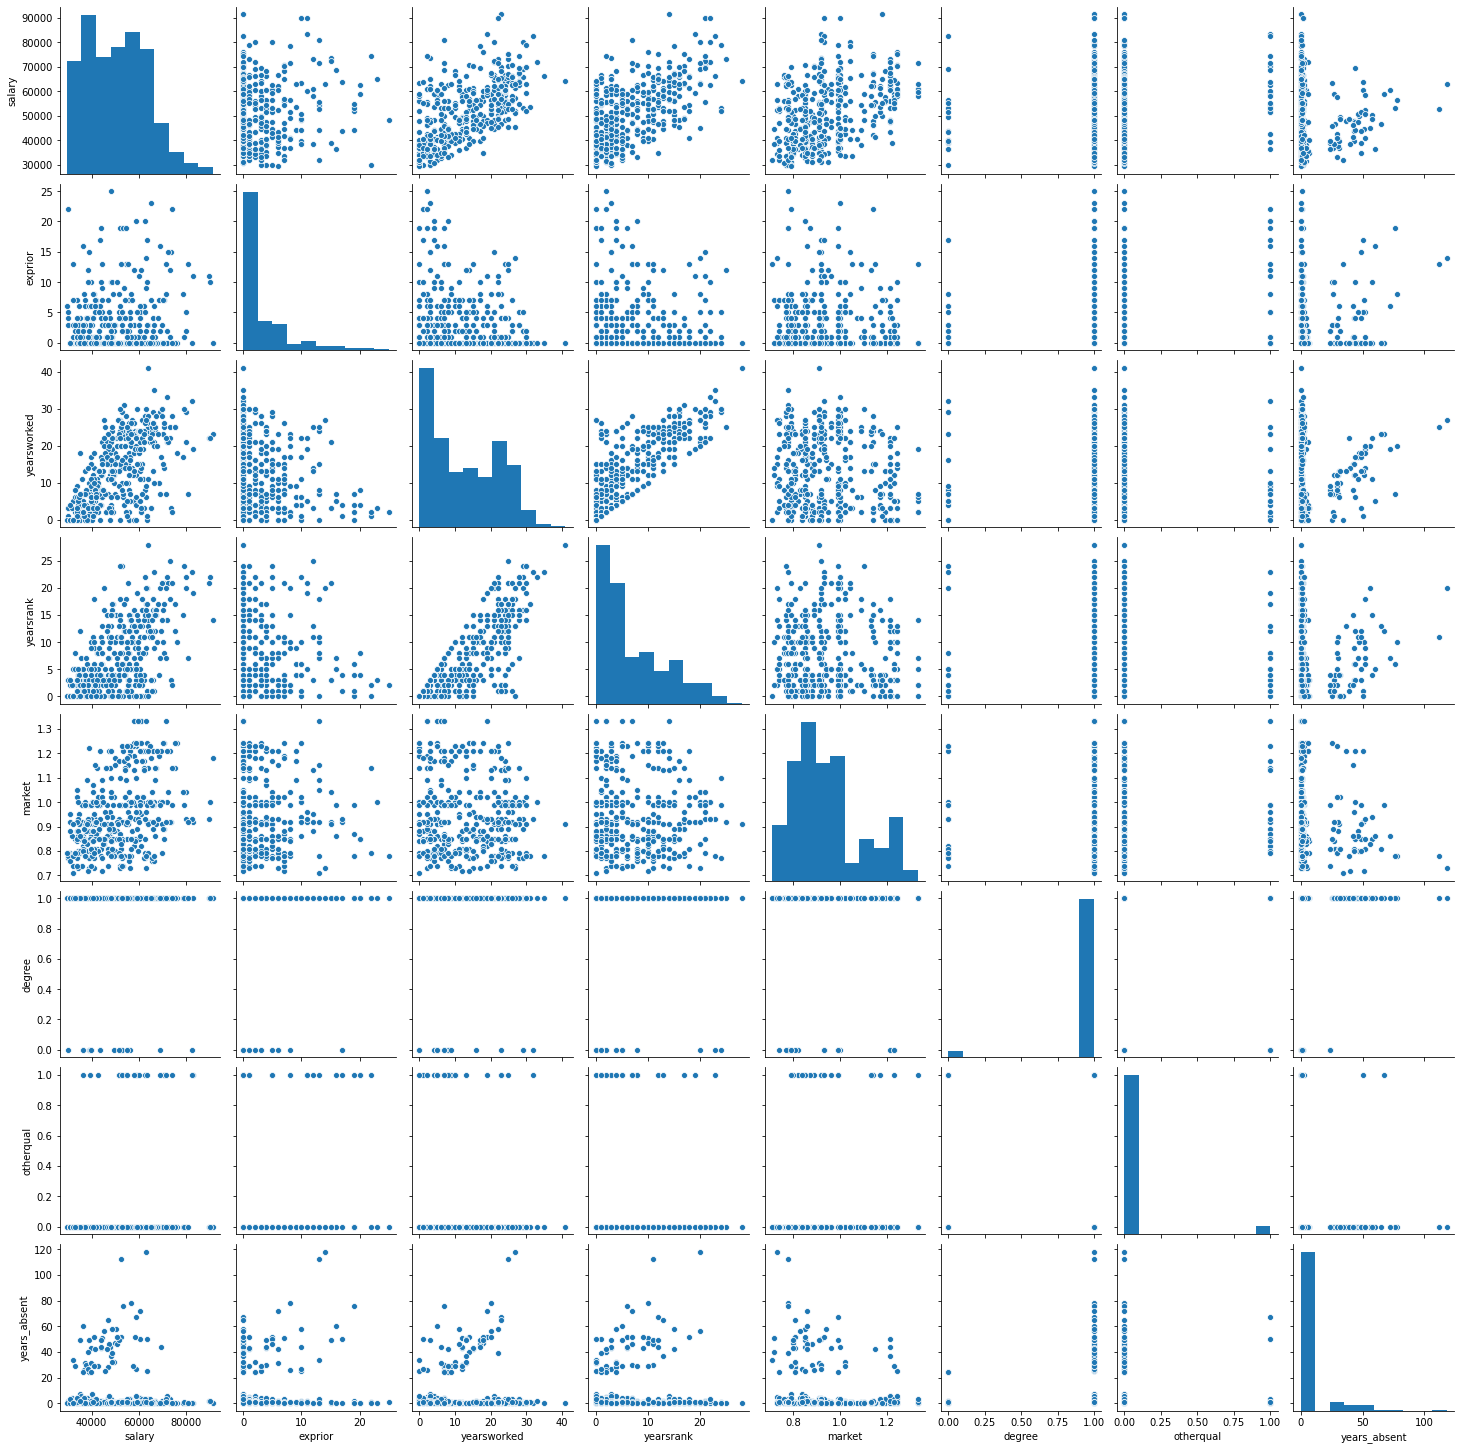

In [4]:
sns.pairplot(df_train)
plt.show()

## Checking and handling outliers

In [5]:
# Quartiles and IQR:df_train
q75_train, q25_train = np.percentile(df_train['salary'], [75 ,25])
iqr_train = q75_train - q25_train

# Extremes' boundaries: df_train
lower_bound = q25_train - iqr_train*1.5
upper_bound = q75_train + iqr_train*1.5

#Determining if an entry is an extreme or an outlier:df_train
df_train['Is_it_an_extreme'] = ['Yes' if i < lower_bound else 'Yes' 
                                if i > upper_bound else "No" 
                                for i in df_train.salary]
df_outliers = df_train[df_train.Is_it_an_extreme == 'Yes']

#Dropping outliers
df_train = df_train[df_train.Is_it_an_extreme != 'Yes']

#df_train descriptive statistics
# df_train.describe()

/home/tshepo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 2. Hot encoding Dummy variables for Field variable with Human Resource, Position with Executive and Gender with Females as references respectively

In [106]:
df_dummies =pd.get_dummies(df_train.Field).loc[:,['Engineering','Finance','Marketing']]
df_dummies1 =pd.get_dummies(df_train.position).loc[:,['Jnr_employee','Manager']]
df_dummies2 =pd.get_dummies(df_train.gender).loc[:,['male']]

df_train = df_train.join(df_dummies)
df_train = df_train.join(df_dummies1)
df_train = df_train.join(df_dummies2)

df_dummies3 =pd.get_dummies(df_test.Field).loc[:,['Engineering','Finance','Marketing']]
df_dummies4 =pd.get_dummies(df_test.position).loc[:,['Jnr_employee','Manager']]
df_dummies5 =pd.get_dummies(df_test.gender).loc[:,['male']]
df_test = df_test.join(df_dummies3)
df_test = df_test.join(df_dummies4)
df_test = df_test.join(df_dummies5)


ValueError: columns overlap but no suffix specified: Index(['Engineering', 'Finance', 'Marketing'], dtype='object')

### 3. correlation matrix comparing the relationship of salary to the predictor variables

In [7]:
df_train.corr(method='pearson').head(1)

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,years_absent,Engineering,Finance,Marketing,Jnr_employee,Manager,male
salary,1.0,0.116332,0.63546,0.609979,0.395646,0.047412,0.162516,-0.070106,0.407335,0.255733,-0.189272,-0.56658,-0.162498,0.38501


### Is there any multicollinearity or other problems that may be a problem in the multiple regression

What the regression model is going to do is to disentangle the individual effects of years worked and years rank on salary. Given the opportunity that the regression model does tease apart these individual effects, such individual effects become obscured. Multicolinearity happens when the X variables are themselves related.

This is a perfect description for multicolinearity, if **one year a experience is added**, the likelihood that one stays in that **rank for one more year** is close to 100%, similarly with **market value**, it is common knowledge that years of experience do actually increase the market value of an individual, so the regression model will have a very unrealistic way of analysing if the effect on salary was due to an increase in market value or due to one more year of experience or one more year of being in that particular rank. Therefore, drop years worked and years absent(the former because it is highly correlated with male but not with salary


### 4. Model creation of salary prediction based on multivariables

In [114]:
import statsmodels.formula.api as smf
# create a fitted model: salary vs Years worked _ Market + Years Rank
variables = ['yearsworked' ,'market' ,'yearsrank','Engineering','Finance' ,'Marketing' ,'Jnr_employee', 'Manager']
model= smf.ols(formula='salary ~ yearsworked + market + yearsrank+ Engineering + Finance + Marketing +Jnr_employee + Manager', data=df_train).fit()
print(color.BOLD + "This model has a higher R-squared (0.816) than the previous model's(0.708), This model provides a better fit to the data than a model that only one variable years worked")
model.summary()

This model has a higher R-squared (0.816) than the previous model's(0.708), This model provides a better fit to the data than a model that only one variable years worked


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     223.0
Date:                Tue, 05 May 2020   Prob (F-statistic):          1.75e-142
Time:                        03:14:15   Log-Likelihood:                -4102.1
No. Observations:                 410   AIC:                             8222.
Df Residuals:                     401   BIC:                             8258.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.587e+04   2138.516     12.098      0.000    2.17e+04    3.01e+04
yearsworked   -311.1699     69.629     -4.469      0.000    -448.053    -174.286
market        3.001e+04   1939.512     15.475      0.000    2.62e+04    3.38e+04
yearsrank      909.8963     76.093     11.958      0.000     760.305    1059.488
Engineering   5479.8591    872.946      6.277      0.000    3763.737    7195.981
Finance       4367.8982    822.212      5.312      0.000    2751.514    5984.283
Marketing      258.7233    771.910      0.335      0.738   -1258.772    1776.218
Jnr_employee -1.778e+04   1089.032    -16.324      0.000   -1.99e+04   -1.56e+04
Manager      -1.049e+04    796.212    -13.173      0.000   -1.21e+04   -8923.473
==============================================================================
Omnibus:                       22.212   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.287
Skew:                           0.482   Prob(JB):                     1.19e-06
Kurtosis:                       3.817   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Evaluation

In [115]:
#model1: predict salary using years worked
df_train1 = model.predict(df_train)
df_train1 = pd.DataFrame(df_train1)

#Mapping 2 columns: Observed salary together with Predicted salary
df_train1['Actual Salary'] = df_train['salary']
df_train1= df_train1.rename(columns={0:'Predicted Salary'})
df_train1['Actual Salary'] = df_train1['Actual Salary'].astype(float)
df_train1['Predicted Salary'] = df_train1['Predicted Salary'].astype(float)




### 5.1 Residuals

In [116]:
#Creating a residual column( a residual vertical distance between a data point and the regression line)
df_train1['Residual'] = (df_train1['Actual Salary'] - df_train1['Predicted Salary'])

#calculating the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
y_actual1 = df_train1['Actual Salary']
y_predicted1 = df_train1['Predicted Salary']
rmse_train = rmse(df_train.salary, model.predict(df_train[variables]))
rmse_test = rmse(df_test.salary, model.predict(df_test[variables]))
# train_rmse = rmse(df_train.salary, model.predict(df_train[variables]))
# test_rmse = rmse(df_test.salary, model.predict(df_test[variables]))
#standardizing residuals
#Standardized residual = (observed count – expected count) / √expected count
df_train1['Standardised Residuals'] = df_train1.Residual/rmse_train
df_risid_fit = df_train1.loc[:,['Residual','Standardised Residuals','Actual Salary','Predicted Salary']]
df_risid_fit


,Residual,Standardised Residuals,Actual Salary,Predicted Salary
320,7020.077369,1.310430,80137.00000,73116.922631
329,-5226.535723,-0.975632,39777.00000,45003.535723
173,8941.440239,1.669089,61453.00000,52511.559761
272,-8438.393621,-1.575185,53665.00000,62103.393621
493,2053.384970,0.383303,44410.85547,42357.470500
...,...,...,...,...
106,8249.086701,1.539848,65212.00000,56962.913299
270,3638.072860,0.679115,68894.00000,65255.927140
348,1808.530653,0.337596,52738.91406,50930.383407
435,2837.275324,0.529631,55210.00000,52372.724676


## Residual plot

In [117]:
px.scatter(data_frame=df_risid_fit
           , y='Residual'
           , x='Predicted Salary'
           , color="Actual Salary"
           , title='Residuals versus Predicted Salary'
           , marginal_y='histogram'
           , opacity=0.2
           , template='seaborn'
          )    

Data points are pretty symmetrically distributed, tending to cluster towards the middle of the plot and  they’re clustered around y = 0 showing no patterns

### 7. Running the model on the test set

In [118]:
# Quartiles and IQR:df_test
q75_test, q25_test = np.percentile(df_test['salary'], [75 ,25])
iqr_test = q75_test - q25_test

# Extremes' boundaries: df_test
test_lower_bound = q25_test - iqr_test*1.5
test_upper_bound = q75_test + iqr_test*1.5

#Determining if an entry is an extreme or an outlier:df_test
df_test['Is_it_an_extreme'] = ['Yes' if i < test_lower_bound else 'Yes'
                               if i > test_upper_bound else "No"
                               for i in df_test.salary]
df_test_outliers = df_test[df_test.Is_it_an_extreme == 'Yes']

#Dropping outliers
df_test = df_test[df_test.Is_it_an_extreme != 'Yes']




In [119]:
#model1: predict salary using years worked
model1= smf.ols(formula='salary ~ yearsworked + market + yearsrank+ Engineering + Finance + Marketing +Jnr_employee + Manager', data=df_test).fit()

df_test1 = model1.predict(df_test)
df_test1 = pd.DataFrame(df_test1)

#Mapping 2 columns: Observed salary together with Predicted salary
df_test1['Actual Salary'] = df_test['salary']
df_test1= df_test1.rename(columns={0:'Predicted Salary'})
df_test1['Actual Salary'] = df_test1['Actual Salary'].astype(float)
df_test1['Predicted Salary'] = df_test1['Predicted Salary'].astype(float)

#Creating a residual column( a residual vertical distance between a data point and the regression line)
df_test1['Residual'] = (df_test1['Actual Salary'] - df_test1['Predicted Salary'])

#standardizing residuals
#Standardized residual = (observed count – expected count) / √expected count
df_test1['Standardised Residuals'] = df_test1.Residual/rmse_test



### 7.1 RMSE Evals

In [120]:
print('The RMSE of the train data is: ',rmse_train)
print('And The RMSE of the test data is: ',rmse_test,'which shows little evidence of underfitting nor underfitting')
print('After such evidence, it is safe to conclude that this is a good model to predict salary.')

The RMSE of the train data is:  5357.07957963371
And The RMSE of the test data is:  5305.517329267747 which shows little evidence of underfitting nor underfitting
After such evidence, it is safe to conclude that this is a good model to predict salary.


## Insight

With the assumptions of linear regression met, it is safe to say that the variables are good predictors of salary. 

# OOP for Data Science

It is efficient to put machine learning models and other data science techniques into classes so that we can reuse them later and change attributes without changing the code behind these models. Independent concepts can also be put into independent classes: for example, the functioning of a cross-validate class should not affect the functioning of a linear regression class.

The classes below illustrate the above concept in it that, this will not only help us compute all that we have done thus far with effeciency but because they can be reused and are designed components that are self-contained.


In [121]:
df_train1 = df_train1.rename(columns={'Residual': 'Residuals', 
                                      'Actual Salary': 'y','Predicted Salary':'y_pred',
                                      'Standardised Residuals':'Stand_Resid'})
df_train1

,y_pred,y,Residuals,Stand_Resid
320,73116.922631,80137.00000,7020.077369,1.310430
329,45003.535723,39777.00000,-5226.535723,-0.975632
173,52511.559761,61453.00000,8941.440239,1.669089
272,62103.393621,53665.00000,-8438.393621,-1.575185
493,42357.470500,44410.85547,2053.384970,0.383303
...,...,...,...,...
106,56962.913299,65212.00000,8249.086701,1.539848
270,65255.927140,68894.00000,3638.072860,0.679115
348,50930.383407,52738.91406,1808.530653,0.337596
435,52372.724676,55210.00000,2837.275324,0.529631


In [122]:
# Class: ErrorCalculator 
class ErrorCalculator:

    def __init__(self, y, y_pred):

        self.y          =   np.array(y)       
        self.y_pred     =   np.array(y_pred)  


    def get_residuals(self):

        residuals = self.y  - self.y_pred
        return residuals

    def get_standardised_residuals(self):

        standardised_residuals = self.get_residuals() / (self.get_residuals()/std())
        return standardised_residuals

    def get_mse(self):

        mse = np.square(np.subtract(self.y, self.y_pred)).mean()
        return mse

    def get_rmse(self):

        rmse = np.sqrt(((self.y_pred - self.y)**2).mean())
        return rmse

    def error_summary(self):
        min_standard = min(self.Standard)
        max_standard = max(self.Standard)
        min_rmse = min(self.rmse)
        max_rmse = max(self.rmse)
        mse_min = min(self.mse)
        mse_max = max(self.mse)
        print(f'standard residual: {min_standard}')
        print(f'standard residual: {max_standard}')
        print(f'min rmse: {min_rmse}')
        print(f'max rmse: {max_rmse}')

In [123]:
#Class: Plotter
class Plotter():
    def __init__(self,y_test,y_pred):
        self.y_test = y_test
        self.ypred = y_pred
    
    def run_calculations(self):
        return self.y_test - self.y_pred
    
    def plot(self):
        plt.hist(self.y_test - self.ypred)
        plt.title('Residuals Plot for predictions')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        return plt.show()

In [124]:
# Class:  histogram plotter
class HistogramPlotter(Plotter):
    def __init__(self, y_test,y_pred):
        Plotter.__init__(self, y_test, y_pred)

   


    

In [125]:
class ScatterPlotter(Plotter):
    def __init__(self, y_test, y_pred):
        Plotter.__init__(self, y_test, y_pred)

    def plot(self):
        chart = pd.DataFrame({"y_test": self.y_test, "y_prediction": self.y_pred})
        chart.plot.scatter(x="y_test", y="y_prediction", c="DarkBlue")
        plt.title("Prediction vs Actual values")
        plt.xlabel("Actual")
        plt.ylabel("Prediction")
        return plt.show()

## Model 1 

In [126]:

df_dummies =pd.get_dummies(df_salary.Field)
df_dummies1 =pd.get_dummies(df_salary.position)
df_dummies2 =pd.get_dummies(df_salary.gender)
original = df_salary.loc[:,['salary','exprior','yearsworked','yearsrank','market','degree','otherqual']]
df_salary1 = pd.concat([original, df_dummies, df_dummies1,df_dummies2] ,axis=1)
df_salary1 =df_salary1.rename(columns ={'Human Resource':'HR'})
df_salary1 = df_salary1.drop(['HR', 'Executive'], axis=1)
df_salary2 = df_salary1.copy()
df_salary1

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,Engineering,Finance,Marketing,Jnr_employee,Manager,female,male
0,53000.0,0,0,0,1.17,1,0,0,0,0,1,0,0,1
1,58000.0,1,0,0,1.24,1,0,0,1,0,1,0,0,1
2,45500.0,0,0,0,1.21,1,0,0,0,0,1,0,0,1
3,35782.0,0,2,1,0.99,1,0,0,0,1,1,0,0,1
4,34731.0,0,2,2,0.91,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,0,1,0,0,1,1,0
510,60402.0,6,19,7,0.86,1,0,1,0,0,0,0,1,0
511,53187.0,19,7,6,0.78,1,0,0,0,1,0,0,1,0
512,56542.0,8,20,10,0.78,1,0,0,1,0,0,0,1,0


In [127]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_salary1.drop(labels=["salary"], axis=1),
                                                    df_salary["salary"],
                                                    test_size = 0.3,
                                                    random_state = 42)

In [128]:
# create a fitted model: salary vs Years worked _ Market + Years Rank
model_1= smf.ols(formula='salary ~ yearsworked + market + yearsrank + Finance + Marketing +Jnr_employee + Manager', data=df_salary1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     223.0
Date:                Tue, 05 May 2020   Prob (F-statistic):          1.75e-142
Time:                        03:14:29   Log-Likelihood:                -4102.1
No. Observations:                 410   AIC:                             8222.
Df Residuals:                     401   BIC:                             8258.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.587e+04   2138.516     12.098      0.000    2.17e+04    3.01e+04
yearsworked   -311.1699     69.629     -4.469      0.000    -448.053    -174.286
market        3.001e+04   1939.512     15.475      0.000    2.62e+04    3.38e+04
yearsrank      909.8963     76.093     11.958      0.000     760.305    1059.488
Engineering   5479.8591    872.946      6.277      0.000    3763.737    7195.981
Finance       4367.8982    822.212      5.312      0.000    2751.514    5984.283
Marketing      258.7233    771.910      0.335      0.738   -1258.772    1776.218
Jnr_employee -1.778e+04   1089.032    -16.324      0.000   -1.99e+04   -1.56e+04
Manager      -1.049e+04    796.212    -13.173      0.000   -1.21e+04   -8923.473
==============================================================================
Omnibus:                       22.212   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.287
Skew:                           0.482   Prob(JB):                     1.19e-06
Kurtosis:                       3.817   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2

In [129]:
# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_salary2.drop(labels=["salary"], axis=1),
                                                    df_salary2["salary"],
                                                    test_size = 0.3,
                                                    random_state = 42)
# create a fitted model: salary vs Years worked _ Market + Years Rank
model_2= smf.ols(formula='salary ~ yearsworked + market + yearsrank+ Finance + Marketing +Jnr_employee + Manager', data=df_salary2).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     276.6
Date:                Tue, 05 May 2020   Prob (F-statistic):          1.97e-168
Time:                        03:14:30   Log-Likelihood:                -5180.2
No. Observations:                 514   AIC:                         1.038e+04
Df Residuals:                     506   BIC:                         1.041e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.519e+04   2004.395     12.569      0.000    2.13e+04    2.91e+04
yearsworked   -286.8291     65.189     -4.400      0.000    -414.904    -158.754
market        3.401e+04   1745.305     19.487      0.000    3.06e+04    3.74e+04
yearsrank      939.0593     73.148     12.838      0.000     795.348    1082.771
Finance        585.7975    645.313      0.908      0.364    -682.025    1853.620
Marketing    -2484.0165    620.313     -4.004      0.000   -3702.723   -1265.310
Jnr_employee -1.902e+04    999.465    -19.026      0.000    -2.1e+04   -1.71e+04
Manager      -1.196e+04    721.130    -16.583      0.000   -1.34e+04   -1.05e+04
==============================================================================
Omnibus:                       37.366   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.766
Skew:                           0.602   Prob(JB):                     4.24e-11
Kurtosis:                       3.884   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
#error calculator
error_model1 = ErrorCalculator(y_test, model.predict(sm.add_constant(X_test)))
error_model2 = ErrorCalculator(y_test2, model_2.predict(sm.add_constant(X_test2)))

# MSE 
print("1st model MSE:  {}".format(error_model1.get_mse()))
print("2nd model MSE:  {}".format(error_model2.get_mse()))

1st model MSE:  33160828.975711107
2nd model MSE:  35703643.66018129


In [131]:
# RMSE
print("1st model RMSE:  {}".format(error_model1.get_rmse()))
print("2nd model RMSE:  {}".format(error_model2.get_rmse()))

1st model RMSE:  5758.543997896613
2nd model RMSE:  5975.252602206981


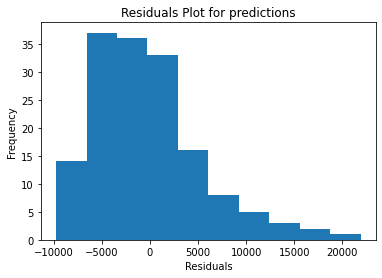

In [132]:
#Model 1 plotting graphs
model1_plot = HistogramPlotter(y_test, model.predict(sm.add_constant(X_test)))
model1_scatter = ScatterPlot(y_test, model.predict(sm.add_constant(X_test)))
# Mode1 Histogram Plot
model1_plot.plot()
